In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from tqdm import tqdm # For LNS progress bar


In [2]:

# ----- Actor (Unified Class) - IDENTICAL to your training setup -----
# This class is needed to load the state_dict from your .pth file.
class Actor(nn.Module):
    def __init__(self, embedding_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.ff_layer = nn.Linear(2, embedding_dim)
        self.gru_encoder = nn.GRU(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.gru_decoder = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.attention = self._Attention(hidden_dim)

    class _Attention(nn.Module):
        def __init__(self, hidden_dim):
            super().__init__()
            self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.W2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

        def forward(self, decoder_hidden, encoder_outputs, mask):
            decoder_hidden_expanded = decoder_hidden.transpose(0, 1) 
            score = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_expanded)))
            score = score.squeeze(-1) 
            score[mask == 0] = -1e9 
            attn_weights = F.softmax(score, dim=-1)
            return attn_weights

    def forward(self, input_coords, seq_len):
        embedded = self.ff_layer(input_coords)
        encoder_outputs, encoder_hidden = self.gru_encoder(embedded)

        batch_size = input_coords.size(0)
        
        decoder_input = embedded[:, 0, :].unsqueeze(1) 
        hidden = encoder_hidden 
        
        mask = torch.ones(batch_size, seq_len, device=input_coords.device)
        mask[:, 0] = 0 # Robot station (index 0) is visited

        tours_batch = [torch.zeros(batch_size, dtype=torch.long, device=input_coords.device)] 

        for _ in range(seq_len - 1): # Select seq_len - 1 other cities
            output, hidden = self.gru_decoder(decoder_input, hidden)
            attn_weights = self.attention(hidden, encoder_outputs, mask)
            
            selected = torch.argmax(attn_weights, dim=-1) # Argmax for deterministic inference
            
            tours_batch.append(selected)
            
            mask.scatter_(1, selected.unsqueeze(-1), 0)
            
            gather_indices = selected.unsqueeze(1).unsqueeze(2).expand(-1, 1, self.embedding_dim)
            decoder_input = torch.gather(encoder_outputs, 1, gather_indices) 

        tours_batch_tensor = torch.stack(tours_batch, dim=1)
        
        return tours_batch_tensor, encoder_outputs


In [3]:
# ----- Functions for Loading and Inference from PTH model -----
def load_actor_model(model_path, embedding_dim=128, hidden_dim=128, device='cpu'):
    device = torch.device(device)
    actor = Actor(embedding_dim, hidden_dim).to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    actor.load_state_dict(checkpoint['actor_state_dict'])
    
    actor.eval()
    print(f"Actor model loaded from {model_path} and set to evaluation mode on {device}.")
    return actor

def infer_tour_single_instance(actor_model, input_coords):
    device = next(actor_model.parameters()).device
    
    input_coords_batched = input_coords.unsqueeze(0).to(device)
    seq_len = input_coords.shape[0]

    with torch.no_grad():
        predicted_tours_batched, _ = actor_model(input_coords_batched, seq_len)
        predicted_tours = predicted_tours_batched.squeeze(0) # Remove batch dimension
        
        inferred_tour_indices = predicted_tours.cpu().numpy().tolist()
        
        original_coords_np = input_coords.cpu().numpy()
        inferred_tour_coords_np = original_coords_np[inferred_tour_indices]
        
        path_coords = np.vstack([inferred_tour_coords_np, inferred_tour_coords_np[0]])
        distances = np.linalg.norm(path_coords[1:] - path_coords[:-1], axis=1)
        tour_length = distances.sum()
        tour_reward = -tour_length

    return inferred_tour_indices, inferred_tour_coords_np, tour_reward


In [4]:
# ----- LNS Helper Functions -----

def calculate_tour_cost(tour_indices, coords):
    """Calculates the total length of a TSP tour."""
    if not tour_indices:
        return float('inf')
    
    path_coords = coords[tour_indices]
    
    # Add the return trip to the starting point (robot station)
    full_path = np.vstack([path_coords, coords[tour_indices[0]]])
    
    distances = np.linalg.norm(full_path[1:] - full_path[:-1], axis=1)
    return np.sum(distances)

def destroy_random(current_tour_indices, num_remove, seq_len):
    """
    Removes a random set of cities from the tour, excluding the robot station (index 0).
    Returns the partial tour indices and the removed cities' indices.
    """
    removable_indices_in_tour = [i for i, city_idx in enumerate(current_tour_indices) if city_idx != 0]
    
    num_remove = min(num_remove, len(removable_indices_in_tour))
    
    indices_to_remove_from_list = random.sample(removable_indices_in_tour, num_remove)
    
    removed_cities = [current_tour_indices[i] for i in sorted(indices_to_remove_from_list, reverse=True)]
    
    partial_tour_indices = list(current_tour_indices)
    for i in sorted(indices_to_remove_from_list, reverse=True):
        del partial_tour_indices[i]
        
    return partial_tour_indices, removed_cities

def repair_greedy(partial_tour_indices, removed_cities, coords):
    """
    Greedily re-inserts removed cities into the partial tour.
    """
    current_tour = list(partial_tour_indices)
    
    for city_to_insert in removed_cities:
        best_insertion_cost = float('inf')
        best_insertion_pos = -1
        
        for j in range(1, len(current_tour) + 1):
            temp_tour = list(current_tour)
            temp_tour.insert(j, city_to_insert)
            
            cost = calculate_tour_cost(temp_tour, coords)
            
            if cost < best_insertion_cost:
                best_insertion_cost = cost
                best_insertion_pos = j
        
        current_tour.insert(best_insertion_pos, city_to_insert)
        
    return current_tour

def simulated_annealing_acceptance(current_cost, new_cost, temperature):
    """
    Accepts new_cost if better, or with a probability if worse (Simulated Annealing).
    """
    if new_cost < current_cost:
        return True
    if temperature <= 0:
        return False
    
    probability = math.exp(-(new_cost - current_cost) / temperature)
    return random.random() < probability

# ----- Main LNS Function -----
def run_lns(initial_tour_indices, original_coords, seq_len, 
            max_iterations, num_remove_per_destroy, initial_temperature, cooling_rate):
    """
    Applies Large Neighborhood Search to improve an initial TSP tour.
    """
    current_tour_indices = list(initial_tour_indices)
    current_cost = calculate_tour_cost(current_tour_indices, original_coords)
    
    best_tour_indices = list(current_tour_indices)
    best_tour_cost = current_cost
    
    temperature = initial_temperature

    print(f"\nStarting LNS. Initial Tour Cost: {current_cost:.4f}")

    for iteration in tqdm(range(max_iterations), desc="LNS Progress"):
        partial_tour_indices, removed_cities = destroy_random(current_tour_indices, num_remove_per_destroy, seq_len)
        
        new_tour_indices = repair_greedy(partial_tour_indices, removed_cities, original_coords)
        new_cost = calculate_tour_cost(new_tour_indices, original_coords)
        
        if simulated_annealing_acceptance(current_cost, new_cost, temperature):
            current_tour_indices = list(new_tour_indices)
            current_cost = new_cost
            
            if current_cost < best_tour_cost:
                best_tour_indices = list(current_tour_indices)
                best_tour_cost = current_cost

        temperature *= cooling_rate
        
    print(f"LNS Finished. Best Tour Cost: {best_tour_cost:.4f}")
    return best_tour_indices, best_tour_cost


In [5]:
# ----- MODIFIED: Side-by-Side Plotting Function -----
def plot_comparison_tours(original_coords, 
                          rl_tour_coords, rl_tour_reward, 
                          lns_tour_coords, lns_tour_reward):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7)) # Two subplots side by side

    # --- Plot 1: RL Model Output ---
    # Plot all original cities as faint points
    ax1.scatter(original_coords[:, 0], original_coords[:, 1], color='lightgray', marker='o', s=50, zorder=1)
    
    # Plot the inferred tour path
    plot_path_coords_rl = np.vstack([rl_tour_coords, rl_tour_coords[0]])
    ax1.plot(plot_path_coords_rl[:, 0], plot_path_coords_rl[:, 1], 'b-o', linewidth=1.5, markersize=8, label='Tour Path', zorder=2)
    
    # Mark the visiting order and points
    for i, (x, y) in enumerate(rl_tour_coords):
        ax1.text(x + 0.01, y + 0.01, str(i + 1), fontsize=9, ha='center', va='center', color='black', weight='bold', zorder=3)
        ax1.scatter(x, y, color='blue', s=100, zorder=3)
    
    # Mark start and end points
    start_x_rl, start_y_rl = rl_tour_coords[0]
    ax1.plot(start_x_rl, start_y_rl, 'go', markersize=12, label='Start Point', zorder=4)
    ax1.text(start_x_rl + 0.02, start_y_rl + 0.02, 'S', fontsize=12, color='darkgreen', weight='bold', ha='center', va='center', zorder=5)
    
    end_x_rl, end_y_rl = rl_tour_coords[-1]
    ax1.plot(end_x_rl, end_y_rl, 'ro', markersize=12, label='End Point', zorder=4)
    ax1.text(end_x_rl - 0.02, end_y_rl - 0.02, 'E', fontsize=12, color='darkred', weight='bold', ha='center', va='center', zorder=5)
    
    ax1.set_title(f'RL Model Output (Length: {-rl_tour_reward:.4f})')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.grid(True, linestyle=':', alpha=0.6)
    ax1.legend()


    # --- Plot 2: LNS Optimized Output ---
    # Plot all original cities as faint points
    ax2.scatter(original_coords[:, 0], original_coords[:, 1], color='lightgray', marker='o', s=50, zorder=1)
    
    # Plot the inferred tour path
    plot_path_coords_lns = np.vstack([lns_tour_coords, lns_tour_coords[0]])
    ax2.plot(plot_path_coords_lns[:, 0], plot_path_coords_lns[:, 1], 'g-o', linewidth=1.5, markersize=8, label='Tour Path', zorder=2) # Green line for LNS
    
    # Mark the visiting order and points
    for i, (x, y) in enumerate(lns_tour_coords):
        ax2.text(x + 0.01, y + 0.01, str(i + 1), fontsize=9, ha='center', va='center', color='black', weight='bold', zorder=3)
        ax2.scatter(x, y, color='green', s=100, zorder=3) # Green markers for LNS
    
    # Mark start and end points
    start_x_lns, start_y_lns = lns_tour_coords[0]
    ax2.plot(start_x_lns, start_y_lns, 'go', markersize=12, label='Start Point', zorder=4)
    ax2.text(start_x_lns + 0.02, start_y_lns + 0.02, 'S', fontsize=12, color='darkgreen', weight='bold', ha='center', va='center', zorder=5)
    
    end_x_lns, end_y_lns = lns_tour_coords[-1]
    ax2.plot(end_x_lns, end_y_lns, 'ro', markersize=12, label='End Point', zorder=4)
    ax2.text(end_x_lns - 0.02, end_y_lns - 0.02, 'E', fontsize=12, color='darkred', weight='bold', ha='center', va='center', zorder=5)
    
    ax2.set_title(f'LNS Optimized (Length: {-lns_tour_reward:.4f})')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.grid(True, linestyle=':', alpha=0.6)
    ax2.legend()

    plt.tight_layout()
    plt.show()

Running on: cuda


C:\Users\progr\AppData\Local\Temp\ipykernel_14640\2584129691.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Actor model loaded from tsp_ac_256_1L.pth and set to evaluation mode on cuda.

--- Initial Tour from RL Model ---
RL Inferred tour (indices): [0, 2, 8, 14, 4, 1, 11, 5, 19, 18, 10, 15, 3, 9, 7, 12, 13, 6, 16, 17]
RL Tour Length: 3.3972

--- Applying LNS to improve RL tour ---

Starting LNS. Initial Tour Cost: 3.3972


LNS Progress: 100%|██████████| 1000/1000 [00:02<00:00, 349.16it/s]


LNS Finished. Best Tour Cost: 3.2208
LNS Optimized tour (indices): [0, 6, 13, 14, 8, 2, 4, 1, 11, 5, 19, 18, 10, 15, 3, 7, 9, 12, 16, 17]
LNS Optimized Tour Length: 3.2208


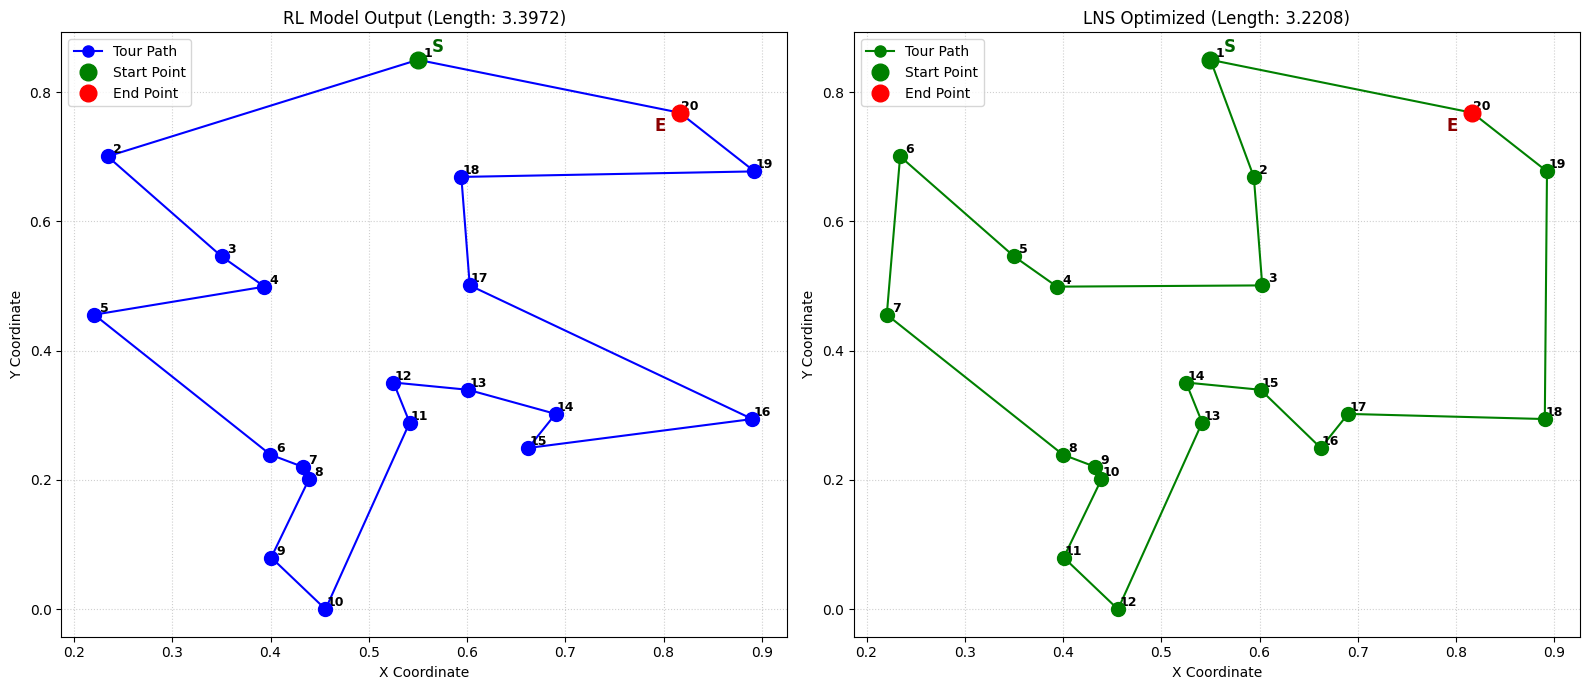


Optimization Summary:
  RL Model Tour Length: 3.3972
  LNS Optimized Tour Length: 3.2208
  LNS improved tour by: 0.1764


In [6]:
# --- Main Execution Block ---
if __name__ == '__main__':
    # Hyperparameters (must match training and ONNX export)
    embedding_dim = 256
    hidden_dim = 256
    seq_len = 20 # Number of cities (including robot station at index 0)

    # Path to your trained PyTorch model
    pth_model_path = 'tsp_ac_256_1L.pth' 

    # LNS Parameters
    lns_max_iterations = 1000 # Number of destroy-repair cycles
    lns_num_remove = 5        # Number of cities to remove in each destroy step (excluding station)
    lns_initial_temp = 1.0    # Starting temperature for SA
    lns_cooling_rate = 0.999  # Rate at which temperature decreases (e.g., 0.999 for slow cooling)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on: {device}")

    try:
        # 1. Load the Actor model (from .pth file)
        loaded_actor = load_actor_model(pth_model_path, embedding_dim, hidden_dim, device)

        # 2. Prepare a single new TSP instance with fixed robot station
        # Robot station is at [0.5, 0.5]
        robot_station_coord = np.array([[0.55, 0.85]], dtype=np.float32)
        # np.random.seed(42) # For reproducibility of this specific problem instance
        # random_other_coords = np.random.rand(seq_len - 1, 2).astype(np.float32)

        #----------------------------
        # Generate random coordinates from a non-uniform distribution (e.g., normal distribution centered at 0.5, 0.5)
        random_other_coords = np.clip(
            np.random.normal(loc=0.5, scale=0.25, size=(seq_len - 1, 2)).astype(np.float32),
            0.0, 1.0
        )
        #----------------------------

        single_instance_coords = np.concatenate([robot_station_coord, random_other_coords], axis=0)
        
        # Convert to torch tensor for inference
        single_instance_coords_torch = torch.from_numpy(single_instance_coords).float()
        
        print(f"\n--- Initial Tour from RL Model ---")
        # 3. Infer initial tour using the RL model
        rl_tour_indices, rl_tour_coords_np, rl_tour_reward = \
            infer_tour_single_instance(loaded_actor, single_instance_coords_torch)
        
        print(f"RL Inferred tour (indices): {rl_tour_indices}")
        print(f"RL Tour Length: {-rl_tour_reward:.4f}")

        # 4. Apply Large Neighborhood Search
        print(f"\n--- Applying LNS to improve RL tour ---")
        lns_best_tour_indices, lns_best_tour_cost = \
            run_lns(rl_tour_indices, single_instance_coords, seq_len,
                    lns_max_iterations, lns_num_remove, lns_initial_temp, lns_cooling_rate)
        
        lns_best_tour_coords_np = single_instance_coords[lns_best_tour_indices]
        lns_best_tour_reward = -lns_best_tour_cost

        print(f"LNS Optimized tour (indices): {lns_best_tour_indices}")
        print(f"LNS Optimized Tour Length: {-lns_best_tour_reward:.4f}")
        
        # 5. Plot both tours side-by-side for comparison
        plot_comparison_tours(single_instance_coords,
                              rl_tour_coords_np, rl_tour_reward,
                              lns_best_tour_coords_np, lns_best_tour_reward)

        print(f"\nOptimization Summary:")
        print(f"  RL Model Tour Length: {-rl_tour_reward:.4f}")
        print(f"  LNS Optimized Tour Length: {-lns_best_tour_reward:.4f}")
        if abs(lns_best_tour_cost) < abs(rl_tour_reward):
             print(f"  LNS improved tour by: {(-rl_tour_reward) - (-lns_best_tour_reward):.4f}")
        else:
             print("  LNS did not find a better solution (or found one of similar quality).")

    except FileNotFoundError:
        print(f"Error: Model file not found at {pth_model_path}.")
        print("Please ensure you have run the training script and the model file exists.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")